# Regridding winds using SSC weighting matrix

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.interpolate import griddata
%matplotlib inline

In [175]:
f = Dataset('weights-gem2.5-ops_201702.nc', 'r')

In [176]:
f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: Salish Sea NEMO GEM 2.5km Operational Atmospheric Forcing Interpolation Weights
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFiles/Atmos/ImproveWeightsFile.ipynb
    references: https://bitbucket.org/salishsea/nemo-forcing/src/tip/grid/weights-gem2.5-ops.nc
    comment: 
    history: [2014-10-23 07:38:25] Converted to netCDF4 zlib=True dataset, and added CF-1.6 metadata.
[2014-10-20 18:42:21] Created netCDF3 classic dataset with NEMO_EastCoast/NEMO_Preparation/4_weights_ATMOS/get_weight_nemo.
 [2017-03-14] Adjust weights for 201702 coordinates.
    dimensions(sizes): x(398), y(898), lon(256), lat(266), numwgt(4)
    variables(dimensions): float64 nav_lat(lat,lon), float64 nav_lon(lat,lon), int64 src01(y,x), float64 wgt01(y,x), int64 src02(y,x), float64 w

In [134]:
# transfer to numpy
src01, src02, src03, src04 = map(np.asarray, (f['src01'], f['src02'], f['src03'], f['src04']))
#account for FORTRAN 1 based indexing
src01, src02, src03, src04 = src01-1, src02-1, src03-1, src04-1

In [135]:
wgt01, wgt02, wgt03, wgt04 = map(np.asarray, (f['wgt01'], f['wgt02'], f['wgt03'], f['wgt04']))

In [136]:
#data
import xarray 
wind = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m01d12.nc')

In [137]:
wind

<xarray.Dataset>
Dimensions:       (time_counter: 24, x: 256, y: 266)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2015-01-12 ... 2015-01-12T23:00:00
  * x             (x) float64 0.0 2.5e+03 5e+03 ... 6.325e+05 6.35e+05 6.375e+05
  * y             (y) float64 0.0 2.5e+03 5e+03 ... 6.575e+05 6.6e+05 6.625e+05
Data variables:
    atmpres       (time_counter, y, x) float32 ...
    nav_lat       (y, x) float64 ...
    nav_lon       (y, x) float64 ...
    precip        (time_counter, y, x) float32 ...
    qair          (time_counter, y, x) float32 ...
    solar         (time_counter, y, x) float32 ...
    tair          (time_counter, y, x) float32 ...
    therm_rad     (time_counter, y, x) float32 ...
    u_wind        (time_counter, y, x) float32 ...
    v_wind        (time_counter, y, x) float32 ...
Attributes:
    Conventions:          CF-1.0
    GRIB2_grid_template:  20
    NCO:                  4.4.2
    History:              Thu Dec 31 12:22:52 2015: ncatted -O -a tim

In [166]:
# get y, x source index arrays with python indexing
y01, x01 = src01//256, src01%256
y02, x02 = src02//256, src02%256
y03, x03 = src03//256, src03%256
y04, x04 = src04//256, src04%256

In [157]:
from numba import jit
@jit
def interpolate(windarr):
    arr = np.transpose(windarr,[1,2,0])
    new_grid = np.zeros([898,398, 24])
    for i in range(898):
        for j in range(398):
            y1,y2,y3,y4 = y01[i][j],y02[i][j],y03[i][j],y04[i][j]
            x1,x2,x3,x4 = x01[i][j],x02[i][j],x03[i][j],x04[i][j]
            w1,w2,w3,w4 = wgt01[i][j], wgt02[i][j], wgt03[i][j], wgt04[i][j]
            s1 = arr[y1][x1]*w1
            s2 = arr[y2][x2]*w2
            s3 = arr[y3][x3]*w3
            s4 = arr[y4][x4]*w4
            new_grid[i][j] = s1+s2+s3+s4
    new_grid = np.transpose(new_grid, [2,0,1])
    return new_grid

In [156]:
%%timeit
interpolate(wind.v_wind.values)
# regular

3.91 s ± 46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [158]:
%%timeit
interpolate(wind.v_wind.values)
#jitted function

198 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [165]:
print(f'jitted gain is {3.91 / 198e-3}')
print(f'gain against scipy is {.805*24 / 198e-3}')

jitted gain is 19.747474747474747
gain against scipy is 97.57575757575758


In [143]:
interpol = interpolate(wind.v_wind.values)

In [144]:
import cmocean

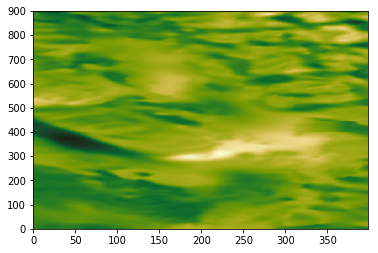

In [145]:
plt.pcolormesh(interpol[1],cmap=cmocean.cm.speed)

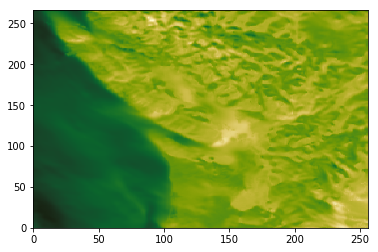

In [146]:
plt.pcolormesh(wind.v_wind.values[1], cmap=cmocean.cm.speed)

## compare with scipy griddata

In [161]:
GEM_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
NEMO_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')
points = np.array([GEM_grid.latitude.values.ravel(), GEM_grid.longitude.values.ravel()-360]).T
xi = (NEMO_grid.latitude.values, NEMO_grid.longitude.values)
data = wind.v_wind.values[1].ravel()

In [163]:
%%timeit
grid_z1 = griddata(points, data, xi, method='linear')

805 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


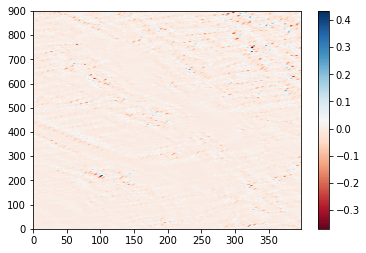

In [149]:
plt.pcolormesh(grid_z1-interpol[1], cmap='RdBu')
plt.colorbar()